# Mixtures
The goal of this notebook is to examine mixtures of outputs from nucleosynthetic processes and, if desired, compare them to cosmochemical data.

Begin by installing and importing the necessary python libraries

In [1]:
import sys, io, requests
from ipywidgets import interact, interactive
import ipywidgets as widgets

!{sys.executable} -m pip install --quiet wnutils
!{sys.executable} -m pip install --quiet matplotlib

import matplotlib.pyplot as plt
import wnutils.xml as wx
import xmlcoll.coll as xc
import numpy as np
from scipy.optimize import curve_fit

# Preliminaries.

Define some routines for the notebook.  First, define a routine to retrieve zone abundances from the xml data.

In [2]:
def get_process_abundances(my_collection, compilation):
    proc = {}
    for process in ['p', 's', 'r']:
        proc[process] = {}
    for item in my_collection.get().values():
        solar_abundance = float(item.get_properties()['solar abundance'])
        for key, value in item.get_properties().items():
            if isinstance(key, tuple) and key[0] == compilation and key[1] == 'fraction':
                proc[key[2]][item.get_name()] = float(value) * solar_abundance
    return proc

Define a routine to retrieve the data for the processes and store in arrays.

In [3]:
def get_proc(sp, norm_species):

    y = []

    proc = {}
    for key in result:
        proc[key] = np.zeros(len(sp))
        count = 0
        for s in sp:
            if s in result[key]:
                proc[key][count] = result[key][s]
            count += 1
            
    for key in result:
        proc[key] /= (np.sum(proc[key]) + 1.e-300) # Add a small amount to denominator in case contribution is zero.
    
    return proc

Define a routine to retrieve mass numbers from a list of species.

In [4]:
def get_mass_numbers(nucs, sp):
    a = np.empty([0])
    for species in sp:
        a = np.append(a, nucs[species]['a'])
    return a

Define a routine to retrieve the element name from a species.

In [5]:
def get_element_string(norm_species):
    result = ""
    for char in norm_species:
        if char.isalpha():
            result += char
        
    return result.capitalize()

Define a routine to get the appropriate string for a species versus the normalizing species.

In [6]:
def get_sp_string(xml, nucs, sp, norm_species):
    return '^{i}\\rm{' + get_element_string(norm_species) + '} / ' + xml.get_latex_names(sp)[norm_species].strip('$')

Finally, define a mass-fractionation-correction routine.  This routine should correct a set of $\mu$ values for isotopes for mass fractionation.  The default is simply to rotate the $\mu$ values about the normalizing species until the $\mu$ of the correction species (relative to the normalizing species) has value zero.

In [7]:
def mass_fractionation_correction(mu, i_norm, i_corr):
    frac_corr = mu[i_corr]
    mu += (a[i_norm] - a) / (a[i_corr] - a[i_norm]) * frac_corr
    return mu

# Retrieve data.

Begin by reading in network data from [OSF](https://osf.io/kjnct/).  Retrieve the nuclides.

In [8]:
xml = wx.Xml(io.BytesIO(requests.get('https://osf.io/kyhbs/download').content))
nucs = xml.get_nuclide_data()

Next, read in the nucleosynthesis processes data and store in a wnutils XML object.  The default is to use files downloaded from [OSF](https://osf.io/967yw/).  To use your own data, put them in your working directory or uploading to Colab or Binder.  Then comment the second line, uncomment the third line, and replace *example.xml* with the chosen name.

In [9]:
rsp = xc.Collection()
rsp.update_from_xml(io.BytesIO(requests.get('https://osf.io/z5wks/download').content))
#rsp.update_from_xml('example.xml')

Retrieve the data for the processes.  Begin by choosing the compilation ('sneden', 'goriely', 'prantzos', or 'bisterzo').

In [10]:
compilation = 'bisterzo'

Now get the data.

In [11]:
result = get_process_abundances(rsp, compilation)

# Study nucleosynthesis mixtures.

Specify the species of interest and the normalizing species.

In [12]:
sp = np.array(['mo92', 'mo94', 'mo95', 'mo96', 'mo97', 'mo98', 'mo100'])
norm_species = 'mo96'

Now set the mass-fractionation correction species (*corr_species*) and the boolean to determine whether to correct anomalies for mass fractionation.  The default is to perform the mass fractionation correction.  If you do not wish to do this, set *correct_for_mass_fractionation* to *False*.

In [13]:
corr_species = 'mo98'
correct_for_mass_fractionation = True

Check that the normalizing and mass-fractionation-correction species are present.  Retrieve mass numbers and strings.

In [14]:
assert norm_species in sp, "Normalizing species not in species list"
assert corr_species in sp, "Mass-fractionation-correction species not in species list"

a = get_mass_numbers(nucs, sp)
element_string = get_element_string(norm_species) 
sp_string = get_sp_string(xml, nucs, sp, norm_species)

Get the process data for the species.  Set the normalization index and mass-fractionation correction species index.  The commented command shows a "hack" to include a small contribution of the p-process to the weak s-process component of the second species.

In [15]:
proc = get_proc(sp, norm_species)
i_norm = np.where(sp == norm_species)
i_corr = np.where(sp == corr_species)

#proc['ws'][1] = 0.05 * proc['p'][1]

In [16]:
a = get_mass_numbers(nucs, sp)

Plot the process contributions.

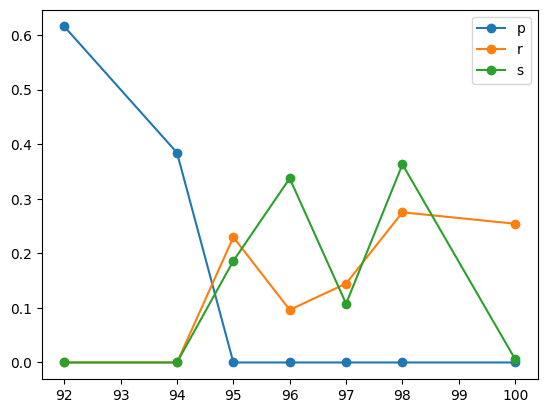

In [17]:
for key in ['p', 'r', 's']:
    plt.plot(a, proc[key], 'o-', label = key)
    
plt.legend()

Input the standard abundance ratios.  Here we use [Anders and Grevesse (1989)](https://osf.io/udvsk/).

In [18]:
y = {}
for item in rsp.get().values():
    y[item.get_name()] = float(item.get_properties()['solar abundance'])

standard = []

for s in sp:
    standard = np.append(standard, y[s] / y[norm_species])

Define a fit function for the processes to the standard abundances.

In [19]:
def fit_function(x, a_p, a_r, a_s):
    result = a_p * proc['p'] + a_r * proc['r'] + a_s * proc['s']
    result /= result[i_norm]
    return result

Compute the best fit to the standard.  Normalize the fit parameters.

In [20]:
popt_std, pcov_std = curve_fit(fit_function, a, standard, bounds=(0, [1, 1, 1]))
popt_std /= np.sum(popt_std)

Plot the fit.

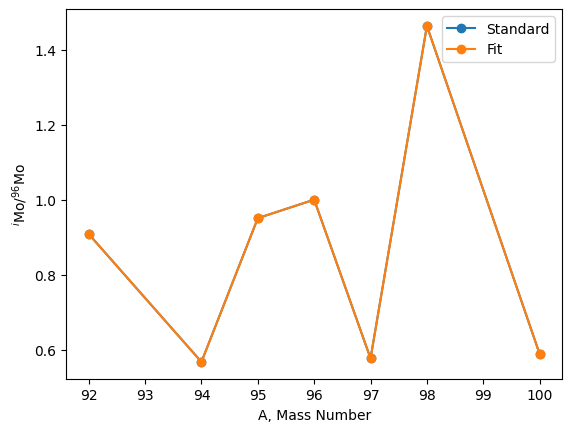

In [21]:
plt.plot(a, standard, '-o', label='Standard')

plt.plot(a, fit_function(a, *popt_std), '-o', label='Fit')

plt.xlabel('A, Mass Number')
plt.ylabel('$' + sp_string + '$')
plt.legend()

With the fit of nucleosynthetic components available, compute and print out the process contributions for each species.  The number in parentheses gives the abundance of the species relative to the normalizing speices in the fit.

In [22]:
c_hash = {'p': 0, 'r': 1, 's': 2}

y_fit = {}
y_sum = np.zeros(len(a))
for key in c_hash:
    y_fit[key] = popt_std[c_hash[key]] * proc[key]
    y_sum += y_fit[key]
    
contribs = {}
    
for key in y_fit:
    contribs[key] = 100. * y_fit[key] / y_sum 
    
for i in range(len(sp)):
    print('{:s} ({:.2f}% of {:s})'.format(sp[i], 100 * y_sum[i] / np.sum(y_sum), element_string))
    for key in contribs:
        print('    {:s}: {:.2f}%'.format(key, contribs[key][i]))
    print("")

mo92 (15.00% of Mo)
    p: 100.00%
    r: 0.00%
    s: 0.00%

mo94 (9.37% of Mo)
    p: 100.00%
    r: 0.00%
    s: 0.00%

mo95 (15.70% of Mo)
    p: 0.00%
    r: 54.60%
    s: 45.40%

mo96 (16.52% of Mo)
    p: 0.00%
    r: 21.80%
    s: 78.20%

mo97 (9.52% of Mo)
    p: 0.00%
    r: 56.70%
    s: 43.30%

mo98 (24.17% of Mo)
    p: 0.00%
    r: 42.50%
    s: 57.50%

mo100 (9.72% of Mo)
    p: 0.00%
    r: 97.70%
    s: 2.30%



Now graphically represent the process contributions to each species.

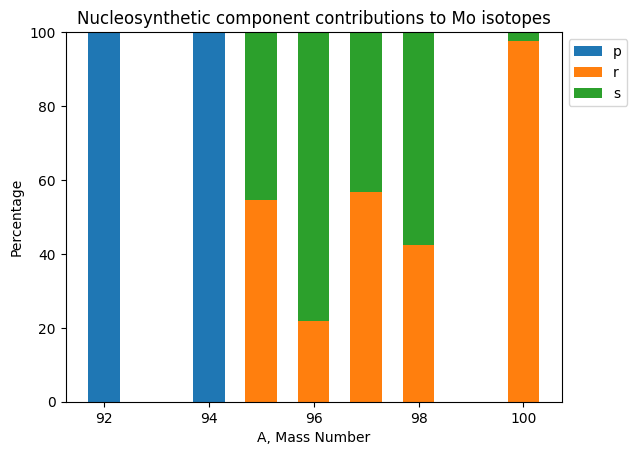

In [23]:
width = 0.6

fig, ax = plt.subplots()
bottom = np.zeros(len(a))

for key, contrib in contribs.items():
    p = ax.bar(a, contrib, width, label=key, bottom=bottom)
    bottom += contrib
    
ax.set_xlabel('A, Mass Number')
ax.set_ylabel('Percentage')
    
ax.set_title('Nucleosynthetic component contributions to {:s} isotopes'.format(element_string))
ax.legend(bbox_to_anchor = (1,1), loc='upper left', ncol = 1)

plt.show()

With appropriate nucleosynthetic contributions now available, you can practice adding and subtracting different mixes of those components (in parts per million). Set *rng* to define the range of variation of the components and *step* to define the increment size. Use the slider bars to adjust the contribution of each component away from the fit to the standard. You can click on a slider and move it, or, once you have clicked on the button, use the left and right arrows on your key board to increase or decrease the contribution. Note that p_proc is the p-process component, r_proc is the r-process component, and s_proc is the s-process component.

In [24]:
rng = 1000
step = 1

def f(p_proc, r_proc, s_proc):
    c_p = (1 + p_proc/1.e6) * popt_std[0]
    c_r = (1 + r_proc/1.e6) * popt_std[1]
    c_s = (1 + s_proc/1.e6) * popt_std[2]

    reference = fit_function(a, *popt_std)
    reference /= reference[i_norm]
    result = c_p * proc['p'] + c_r * proc['r'] + c_s * proc['s']
    result /= result[i_norm]
    mu = 1.e6 * (result / reference - 1)
    
    if correct_for_mass_fractionation:
        mu = mass_fractionation_correction(mu, i_norm, i_corr)
    
    plt.plot(a, mu, '-o', label='fit')

    plt.xlabel('A, Mass Number')
    plt.ylabel('$\\mu(' + sp_string + ')$')
        
    plt.show()
        
interact(f, p_proc=(-rng,rng,step), r_proc=(-rng,rng,step), s_proc=(-rng,rng,step))#ms_proc=(-rng,rng,step), ws_proc=(-rng,rng,step))

interactive(children=(IntSlider(value=0, description='p_proc', max=1000, min=-1000), IntSlider(value=0, descri…

<function __main__.f(p_proc, r_proc, s_proc)>

# Compare to data.

This section allows the user to compare nucleosynthetic mixtures to data.  The default is not to run the comparison, as the following cell sets empty arrays for the data and error values.

In [25]:
data = []
error = []

Add data, if desired.  The *data* array shows the deviations from the standard for each species (in parts per million) while *error* is the array giving the uncertainty for each data point.  The *data* and *error* arrays need to match up with the *a* and *sp* arrays defined above.

To compare to data, uncomment the two lines of the cell, replace the data and error arrays with your own values, and run the following cells.  Make sure that no error value is zero as this will cause a problem with the fits.

In [26]:
#data = np.array([-54.1, -26.1, -3.4, 0., 11.3, 0., -40.9])
#error = np.array([34.0, 10.1, 3.9, 0.1, 2.5, 0.1, 9.5])

Check for zero error values.

In [27]:
if len(data) > 0:
    assert np.all(error), "An error value is zero."

Define a fit function for the anomaly data.

In [28]:
if len(data) > 0:
    def fit_function2(x, a_p, a_r, a_s):
        result = a_p * proc['p'] + a_r * proc['r'] + a_s * proc['s']
        result /= result[i_norm]    
        reference = fit_function(x, *popt_std)
        mu = 1.e6 * ((result / reference) - 1)
        if correct_for_mass_fractionation:
            mass_fractionation_correction(mu, i_norm, i_corr)
        return mu

Fit the data.  Normalize the fit parameters.

In [29]:
if len(data) > 0:
    popt_mu, pcov_mu = curve_fit(fit_function2, a, data, bounds=(0, [1, 1, 1]), sigma=error)
    popt_mu /= np.sum(popt_mu)

Print the fit parameters.

In [30]:
if len(data) > 0:
    a_fit = 1.e6 * (popt_mu/np.sum(popt_mu)/(popt_std/np.sum(popt_std)) - 1)

    print('p_proc: {:.2f}'.format(a_fit[0]))
    print('r_proc: {:.2f}'.format(a_fit[1]))
    print('s_proc: {:.2f}'.format(a_fit[2]))

Add and subtract nucleosynthetic components (in parts per million) to fit the data. Use the slider bars to adjust the contribution of each component. You can click on a slider and move it, or, once you have clicked on the button, use the left and right arrows on your key board to increase or decrease the contribution. Note that p_proc is the p-process component, r_proc is the r-process component, ms_proc is the main s-process component, and ws_proc is the weak s-process component.

The plot starts with the best fit parameters from the cell above.

In [31]:
if len(data) > 0:
    def f(p_proc, r_proc, s_proc):
        c_p = (1 + p_proc/1.e6) * popt_std[0]
        c_r = (1 + r_proc/1.e6) * popt_std[1]
        c_s = (1 + s_proc/1.e6) * popt_std[2]

        reference = fit_function(a, *popt_std)
        reference /= reference[i_norm]
        result = c_p * proc['p'] + c_r * proc['r'] + c_s * proc['s']
        result /= result[i_norm]
        mu = 1.e6 * (result / reference - 1)
        
        if correct_for_mass_fractionation:
            mass_fractionation_correction(mu, i_norm, i_corr)

        plt.plot(a, mu, '-o', label='fit')
        plt.errorbar(a, data, fmt='-o', yerr=error, label='data')

        plt.xlabel('A, Mass Number')
        plt.ylabel('$\\mu(' + sp_string + ')$')
        plt.legend()
        
        plt.show()
       
    interact(f, p_proc=a_fit[0], r_proc=a_fit[1], s_proc=a_fit[2])